## Benchmarking Ray.put calls

In [1]:
import ray
import numpy as np
import random
import string
import timeit
import time

ray.init()

Waiting for redis server at 127.0.0.1:45901 to respond...
Waiting for redis server at 127.0.0.1:24668 to respond...
Starting local scheduler with the following resources: {'GPU': 0, 'CPU': 4}.

View the web UI at http://localhost:8890/notebooks/ray_ui73273.ipynb?token=f11617d6208e00ba2755c56d753a43eb6bb185c92115f24e



{'local_scheduler_socket_names': ['/tmp/scheduler89809200'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store41608887', manager_name='/tmp/plasma_manager44539453', manager_port=32897)],
 'redis_address': '127.0.0.1:45901',
 'webui_url': 'http://localhost:8890/notebooks/ray_ui73273.ipynb?token=f11617d6208e00ba2755c56d753a43eb6bb185c92115f24e'}

In [2]:
# Create 20 Million Random Strings of length 20
NUM_STRINGS = 2*10**7
STRING_LENGTH = 100

d = []
for i in range(NUM_STRINGS):
    d.append(''.join(random.choice(string.ascii_letters) for _ in range(20)))

In [3]:
import sys
print("Size of data: " + str(sys.getsizeof(d)/1024/1024) + " MB")

Size of data: 157 MB


In [4]:
partitions_to_wall_time = {}
d = np.array(d)
partitions_to_try = [1, 10, 100, 1000, 5000, 10000, 50000, 100000]

for i in partitions_to_try + partitions_to_try[::-1]:
    x = np.array_split(d, i)
    t_start = time.time()
    ray.wait([ray.put(k) for k in x], len(x))
    t_end = time.time()
    if i not in partitions_to_wall_time:
        partitions_to_wall_time[i] = []
    partitions_to_wall_time[i].append(t_end - t_start)

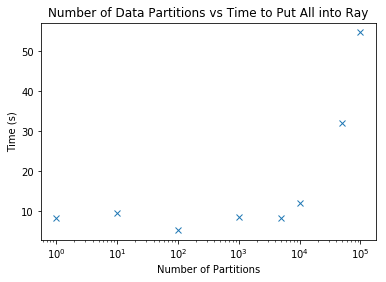

In [5]:
import matplotlib.pyplot as plt
keys = partitions_to_wall_time.keys()
values = [np.mean(partitions_to_wall_time[k]) for k in keys]
plt.plot(keys, values, 'x')
plt.title('Number of Data Partitions vs Time to Put All into Ray')
plt.xlabel('Number of Partitions')
plt.ylabel('Time (s)')
plt.xscale('log')
plt.show()